# Import needed packages
based on sklearn 0.21

In [200]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors.kde import KernelDensity
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score, train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler,Normalizer, OneHotEncoder, CategoricalEncoder
from sklearn.compose import ColumnTransformer
from sklearn import svm
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline

import lime
import lime.lime_tabular

# Data Preparation 

## import data

In [2]:
# read in and prepare X_train, y_train and X_test data
train=pd.read_csv('MLProjectData.csv')
X_target=pd.read_csv('testData.csv',index_col=0) # test data has index needed to remove

## check data for na value

In [9]:
train.isna().any().sum()
# train.info()

0

In [10]:
X_target.isna().any().sum()
# train.info()

0

In [11]:
# train.dropna(subset=['na feature'])
# train.drop('na feature', axis=1)
# train.['na feature'].fillna(median, inplace=True)

## Check parameters

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000216B2464D68>,
        ...,
        ...,
        ...,
       ...,
        ...,
        ...,
        ...,
      dtype=object)

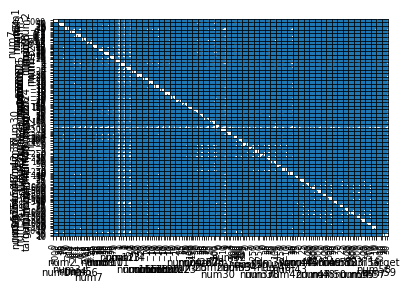

In [75]:
pd.plotting.scatter_matrix(train.select_dtypes(exclude=['object','bool']))

## Stratify train test split

In [3]:
# Stratify the training test based on category variable ['cat1','cat2']

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(train, train[['cat1','cat2']]):
    strat_train_set = train.loc[train_index]
    strat_test_set = train.loc[test_index]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000216B18FB7F0>,
      dtype=object)

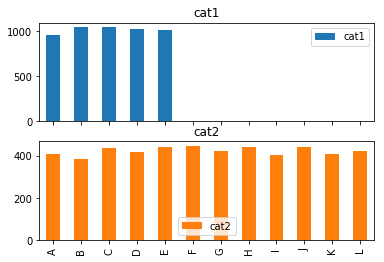

In [4]:
strat_train_set[['cat1','cat2']].apply(pd.value_counts).plot(kind='bar', subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000216B1E4EC88>,
      dtype=object)

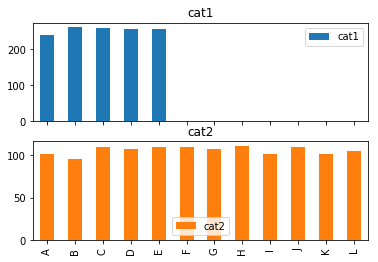

In [5]:
strat_test_set[['cat1','cat2']].apply(pd.value_counts).plot(kind='bar', subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000216B20684E0>,
      dtype=object)

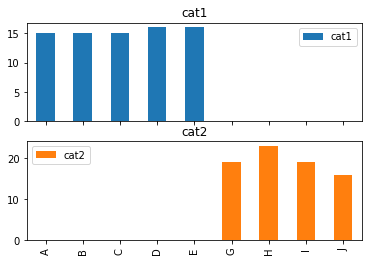

In [6]:
X_target[['cat1','cat2']].apply(pd.value_counts).plot(kind='bar', subplots=True)

## Handeling Text and Categorical features Using onehotencoder

Use select_dtypes to seperate label & numeric columns

In [93]:
X_train = strat_train_set.drop('target',axis = 1)
y_train = strat_train_set['target']

X_test = strat_test_set.drop('target',axis = 1)
y_test = strat_test_set['target']

In [94]:
X_train.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('O'), dtype('bool')],
      dtype=object)

In [96]:
# Category
col_cat = X_train.select_dtypes(include=['object']).columns
print(col_cat)
X_train[col_cat].head()

Index(['cat1', 'cat2'], dtype='object')


,cat1,cat2
168,C,A
5112,A,G
3979,A,K
4864,C,L
4903,B,K


In [97]:
# Numeric
col_num = X_train.select_dtypes(exclude=['object','bool']).columns
print(col_num)
X_train[col_num].head()

Index(['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9',
       'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17',
       'num18', 'num19', 'num20', 'num21', 'num22', 'num23', 'num24', 'num25',
       'num26', 'num27', 'num28', 'num29', 'num30', 'num31', 'num32', 'num33',
       'num34', 'num35', 'num36', 'num37', 'num38', 'num39', 'num40', 'num41',
       'num42', 'num43', 'num44', 'num45', 'num46', 'num47', 'num48', 'num49',
       'num50', 'num51', 'num52', 'num53', 'num54', 'num55', 'num56', 'num57',
       'num58', 'num59'],
      dtype='object')


,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,...,num50,num51,num52,num53,num54,num55,num56,num57,num58,num59
168,61.999,22.03,1.687500,0.002988,0.010888,0.033144,0.010185,21.57,23.25,23.24,...,-68.531212,38.55925,-4.661718,-2.217615,-96.943525,-6.998446,-4.098455,-68.531212,1.781296,2015
5112,4.713,13.78,0.218803,0.008616,0.012150,0.016425,0.005105,13.68,14.19,15.23,...,-5.631816,34.85750,-3.487733,-0.979806,-30.897320,39.260090,-2.722662,-5.631816,0.125000,865
3979,59.920,26.93,1.687500,0.008806,0.029443,-0.025303,-0.053901,26.00,27.71,26.62,...,84.790800,53.63239,2.319842,2.635343,78.129300,87.535490,2.335897,84.790800,2.843704,1976
4864,4.103,9.31,0.093800,0.006725,0.003350,-0.002001,0.005373,10.08,10.75,11.08,...,-157.119700,26.57481,-7.484016,-4.758474,-187.611600,-81.581250,-6.411956,-157.119700,0.031200,228
4903,1227.818,18.56,-2.759995,-0.007245,-0.007199,-0.013880,-0.012634,17.06,16.19,15.36,...,62.710150,67.36261,4.387445,2.011711,74.230980,62.570940,2.741952,62.710150,0.000000,5983


In [98]:
# boolean
col_bool = X_train.select_dtypes(include=['bool']).columns
print(col_bool)
X_train[col_bool].head()

Index(['cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10',
       'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18',
       'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26'],
      dtype='object')


,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,...,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26
168,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
5112,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3979,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4864,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4903,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### OneHotEncoder
just an example, using columntransformer instead

In [174]:
encoder = OneHotEncoder(sparse=False)

cat_1hot = encoder.fit_transform(train[['cat1','cat2']])
print(cat_1hot.shape)
print(encoder.categories_)

(6350, 17)
[array(['A', 'B', 'C', 'D', 'E'], dtype=object), array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L'],
      dtype=object)]


In [226]:
feature_names = col_num.tolist() + ['cat1_' + i for i in encoder.categories_[0]] + ['cat2_' + i for i in encoder.categories_[1]] + col_bool.tolist()

In [229]:
categorical_feature_names = ['cat1_' + i for i in encoder.categories_[0]] + ['cat2_' + i for i in encoder.categories_[1]] + col_bool.tolist()

In [230]:
len(col_num)

59

In [237]:
categorical_feature_id = list(range(59,100))

# Pipeline

## ColumnTransformer

In [155]:
ct = ColumnTransformer([('num',Normalizer(norm='l1'),col_num),('cat',OneHotEncoder(sparse=False),col_cat),('bool','passthrough',col_bool)])

In [175]:
X_train_prepared = ct.fit_transform(X_train)
X_train_prepared.shape

(5080, 100)

In [176]:
print(ct.transformers_)
print(ct.get_feature_names)

[('num', Normalizer(copy=True, norm='l1'), Index(['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9',
       'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17',
       'num18', 'num19', 'num20', 'num21', 'num22', 'num23', 'num24', 'num25',
       'num26', 'num27', 'num28', 'num29', 'num30', 'num31', 'num32', 'num33',
       'num34', 'num35', 'num36', 'num37', 'num38', 'num39', 'num40', 'num41',
       'num42', 'num43', 'num44', 'num45', 'num46', 'num47', 'num48', 'num49',
       'num50', 'num51', 'num52', 'num53', 'num54', 'num55', 'num56', 'num57',
       'num58', 'num59'],
      dtype='object')), ('cat', OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False), Index(['cat1', 'cat2'], dtype='object')), ('bool', 'passthrough', Index(['cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10',
       'cat11', 'cat12', 'cat13', 'cat14', 'cat15',

## Pipeline

In [ ]:
# omitted for using columntransformer

# Benchmark 

## median and mean

In [96]:
y_train.describe()

count    6350.000000
mean       20.035933
std         1.419549
min         8.479981
25%        19.453096
50%        20.062500
75%        20.680000
max        32.849998
Name: target, dtype: float64

In [117]:
y_mean=np.repeat(y_train.mean(), len(y_train))
y_median=np.repeat(y_train.median(), len(y_train))
print('Benchmark\nMean:\nR2:',r2_score(y_train, y_mean)) 
print('MAE:',mae(y_train, y_mean)) 
print('Median:\nR2:',r2_score(y_train, y_median)) 
print('MAE:',mae(y_train, y_median)) 

Benchmark
Mean:
R2: 1.1102230246251565e-16
MAE: 0.9567985025831722
Median:
R2: -0.0003503183503301699
MAE: 0.9563565006299212


## kernel density

In [91]:
y_train_array = y_train.values[:,np.newaxis]

kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(y_train_array)
kde.score_samples(y_train_array)

print('MAE:',mae(y_train_array,kde.sample(len(y_train_array)))) 

MAE: 1.4492191158844947


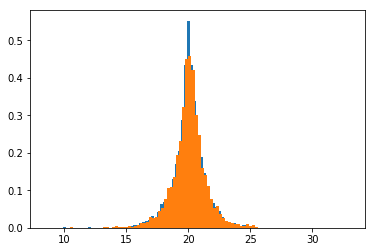

In [94]:
# Visualize the target
plt.hist(y_train,bins=100,density=0.5);
# y_train.quantile(q=0.05)
# y_train.quantile(q=0.95)
plt.hist(kde.sample(len(y_train_array)),bins=100,density=0.5);

# SVR

## Grid Search

In [37]:
# # Dont run takes 90+ minutes

# svr_grid = svm.SVR()

# params_svr = {'C': [0.0001,0.001,0.005,0.1,0.3,0.5,1,3,5], 
#               'gamma': [5,4,3,2,1.5,1,0.9,0.8,0.5],
#               'kernel': ['rbf']}

# grid_svr = GridSearchCV(svr_grid, params_svr,cv=10)
# grid_svr.fit(X_train_norm, y_train)

# # Print the MAE score
# # print('Training MAE:', mae(y_train, grid_svr.best_estimator_.predict(X_train_norm)))

Training MAE: 0.9563635396782749


In [182]:
# Dont run takes 90+ minutes
params_svr = {'C': [0.0001,0.001,0.005,0.1,0.3,0.5,1,3,5], 
              'gamma': [5,4,3,2,1.5,1,0.9,0.8,0.5],
              'kernel': ['rbf']}

grid_svr = RandomizedSearchCV(svm.SVR, params_svr,cv=5,scoring='neg_mean_absolute_error')
grid_svr.fit(X_train_prepared, y_train)

# Print the MAE score
# print('Training MAE:', mae(y_train, grid_svr.best_estimator_.predict(X_train_norm)))

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'C': [0.0001, 0.001, 0.005, 0.1, 0.3, 0.5, 1, 3, 5], 'gamma': [5, 4, 3, 2, 1.5, 1, 0.9, 0.8, 0.5], 'kernel': ['rbf']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [183]:
grid_svr.best_params_

{'kernel': 'rbf', 'gamma': 2, 'C': 0.005}

In [184]:
grid_svr.best_score_

-0.9563479315059327

## Evaluate Final Model

In [192]:
model_final = svm.SVR.set_params(grid_svr.best_estimator_)

In [193]:
model_final.fit(X_train_prepared,y_train)

SVR(C=0.005, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=2,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [194]:
X_test_prepared = ct.transform(X_test)

In [196]:
model_final.score(X_test_prepared, y_test)

-0.0007704956825831388

In [197]:
y_test_pred = model_final.predict(X_test_prepared)

In [198]:
mae(y_test, y_test_pred)

0.9564183378118806

### Lime

In [240]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_prepared, mode = 'regression', 
                                                   feature_names=feature_names, 
                                                   categorical_features = categorical_feature_id
                                                  )

In [263]:
i = 300

In [265]:
exp = explainer.explain_instance(X_test_prepared[i], model_final.predict, num_features = 100)

In [266]:
exp.show_in_notebook(show_table=True)

In [267]:
exp.as_list()

[('cat1_A=0', 0.005355569903751102),
 ('cat2_C=0', 0.0036602140889544256),
 ('cat1_B=0', -0.003421819042111194),
 ('cat2_J=0', 0.003011614327128),
 ('cat2_D=0', -0.0027517738864986786),
 ('cat2_F=0', 0.0026768582312012364),
 ('cat2_H=0', 0.0025168415322369226),
 ('cat23=0', 0.002364186016808241),
 ('cat19=0', 0.0023142168651171208),
 ('cat11=0', 0.0022441803431941724),
 ('cat2_K=0', -0.0021795622499718712),
 ('cat8=0', 0.002004047128322298),
 ('cat6=0', 0.0018627609880157018),
 ('cat5=0', 0.0018463014018179154),
 ('cat12=0', 0.0017888397008671497),
 ('cat14=0', 0.0017875159689000222),
 ('cat7=0', 0.001616829374664949),
 ('cat25=0', 0.0016031958714993423),
 ('cat17=0', 0.0015135179290139207),
 ('cat10=0', 0.0014568642797102274),
 ('cat2_A=0', -0.0013886272751461768),
 ('cat15=0', 0.001303630075522036),
 ('cat20=0', 0.0012573589573887593),
 ('cat21=1', -0.0012567637798587923),
 ('cat1_E=0', 0.0012509251148954208),
 ('cat16=0', 0.0012479998155423937),
 ('cat2_G=0', 0.0012144088995425294),

## Gridsearch results (candidates)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.5,
kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
  
SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR(C=0.001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=5,
kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## Cross Validation best model

### Standardized Data

In [6]:
svr_validate = svm.SVR(C=3,degree=3,gamma=0.9,kernel='rbf')

scores = cross_val_score(svr_validate, X_train_std, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.98771723 -0.93132544 -1.00851058 -0.9137543  -0.89537944 -0.97483196
 -0.94677773 -0.99193567 -0.9394993  -0.97780779]
-0.9567539434416366


### Normalized Data (works better)

In [154]:
svr_validate = svm.SVR(C=3,degree=3,gamma=0.9,kernel='rbf')

scores = cross_val_score(svr_validate, X_train_norm, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.9908526  -0.93328811 -1.0075597  -0.91038571 -0.88694411 -0.97235694
 -0.94409592 -0.99034215 -0.94005804 -0.97752778]
-0.9553411052541234


### Output result

In [30]:
result = svr_final.predict(X_test_norm)

(array([12., 31., 18.,  2.,  6.,  2.,  2.,  1.,  1.,  2.]),
 array([20.06090585, 20.06534632, 20.06978679, 20.07422726, 20.07866773,
        20.0831082 , 20.08754867, 20.09198914, 20.09642961, 20.10087008,
        20.10531055]),
 <a list of 10 Patch objects>)

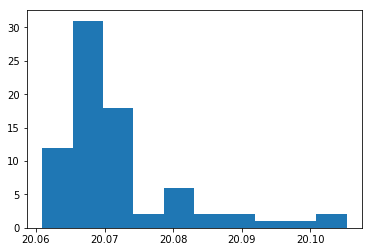

In [31]:
plt.hist(result)

In [32]:
len(result)

77

In [35]:
result.tofile('result.csv',sep='\n')

## PCA + SVR (unsuccessful try)

In [150]:
svr_grid = svm.SVR()

params_svr = {'C': [3,4,5,6,7,8], 
              'gamma': [5,4,3,2,1,0.5],
              'kernel': ['rbf']}

grid_svr = GridSearchCV(svr_grid, params_svr,cv=5)
grid_svr.fit(X_train_pca, y_train)

Training MAE: 0.11878177387367138


In [152]:
# Cross Validation
svr_validate = svm.SVR(C=4,degree=3,gamma=4,kernel='rbf')
# svr_validate = svm.SVR(gamma='auto')

scores = cross_val_score(svr_validate, X_train_pca, y_train, cv=10, scoring = 'neg_mean_absolute_error')
print(scores)
print(np.mean(scores))

[-0.9878083  -0.93158894 -1.00834542 -0.9140054  -0.89540323 -0.97501114
 -0.94688645 -0.99214737 -0.93950996 -0.9777393 ]
-0.9568445504223
